In [1]:
import os
import tempfile
import warnings
from os.path import join as pjoin

import dask
import dask.dataframe as dd
import dask_geopandas as dgpd
import geopandas as gpd
import numpy as np
import pandas as pd
import rasterio
from scipy.fft import dst
import tqdm
import xarray as xr
from dask.diagnostics import ProgressBar
from rasterio.crs import CRS

from raster_tools import Raster, Vector, open_vectors, clipping, zonal
from raster_tools.dtypes import F32, U8, U16

# Filter out warnings from dask_geopandas and dask
warnings.filterwarnings(
    "ignore", message=".*initial implementation of Parquet.*"
)
warnings.filterwarnings(
    "ignore", message=".*Slicing is producing a large chunk.*"
)


# Location for temporary storage
TMP_LOC = "data/temp/"
DATA_LOC = "data/"

STATE = "OR"

# Location of clipped DEM files
DEM_DATA_DIR = pjoin(TMP_LOC, "dem_data")

# location of feature data files
FEATURE_DIR = pjoin(DATA_LOC, "FeatureData")
EDNA_DIR = pjoin(DATA_LOC, "terrain")
MTBS_DIR = pjoin(DATA_LOC, "MTBS_Data")

PATHS = {
    "states": pjoin(EDNA_DIR, "state_borders/cb_2018_us_state_5m.shp"),
    "dem": pjoin(EDNA_DIR, "us_orig_dem/us_orig_dem/orig_dem/hdr.adf"),
    # "dem_slope": pjoin(EDNA_DIR, "us_slope/us_slope/slope/hdr.adf"),
    # "dem_aspect": pjoin(EDNA_DIR, "us_aspect/aspect/hdr.adf"),
    # "dem_flow_acc": pjoin(EDNA_DIR, "us_flow_acc/us_flow_acc/flow_acc/hdr.adf"),
    "gm_srad": pjoin(FEATURE_DIR, "gridmet/srad_1986_2020_weekly.nc"),
    "gm_vpd": pjoin(FEATURE_DIR, "gridmet/vpd_1986_2020_weekly.nc"),
    "aw_mat": pjoin(FEATURE_DIR, "adaptwest/Normal_1991_2020_MAT.tif"),
    "aw_mcmt": pjoin(FEATURE_DIR, "adaptwest/Normal_1991_2020_MCMT.tif"),
    "aw_mwmt": pjoin(FEATURE_DIR, "adaptwest/Normal_1991_2020_MWMT.tif"),
    "aw_td": pjoin(FEATURE_DIR, "adaptwest/Normal_1991_2020_TD.tif"),
    "dm_tmax": pjoin(FEATURE_DIR, "daymet/tmax_1986_2020.nc"),
    "dm_tmin": pjoin(FEATURE_DIR, "daymet/tmin_1986_2020.nc"),
    "biomass_afg": pjoin(
        FEATURE_DIR, "biomass/biomass_afg_1986_2020_{}.nc".format(STATE)
    ),
    "biomass_pfg": pjoin(
        FEATURE_DIR, "biomass/biomass_pfg_1986_2020_{}.nc".format(STATE)
    ),
    "landfire_fvt": pjoin(
        FEATURE_DIR, "landfire/LF2020_FVT_200_CONUS/Tif/LC20_FVT_200.tif"
    ),
    "landfire_fbfm40": pjoin(
        FEATURE_DIR, "landfire/LF2020_FBFM40_200_CONUS/Tif/LC20_F40_200.tif"
    ),
    "ndvi": pjoin(FEATURE_DIR, "ndvi/access/weekly/ndvi_1986_2020_weekavg.nc"),
    "mtbs_root": pjoin(MTBS_DIR, "MTBS_BSmosaics/"),
    "mtbs_perim": pjoin(MTBS_DIR, "mtbs_perimeter_data/mtbs_perims_DD.shp"),
}
YEARS = [2020]
GM_KEYS = list(filter(lambda x: x.startswith("gm_"), PATHS)) 
AW_KEYS = list(filter(lambda x: x.startswith("aw_"), PATHS)) 
DM_KEYS = list(filter(lambda x: x.startswith("dm_"), PATHS)) 
BIOMASS_KEYS = list(filter(lambda x: x.startswith("biomass_"), PATHS)) 
LANDFIRE_KEYS = list(filter(lambda x: x.startswith("landfire_"), PATHS)) 
NDVI_KEYS = list(filter(lambda x: x.startswith("ndvi"), PATHS)) 
DEM_KEYS = list(filter(lambda x: x.startswith("dem"), PATHS))
mtbs_df_path = pjoin(TMP_LOC, f"{STATE}_mtbs_NEW.parquet")
mtbs_df_temp_path = pjoin(TMP_LOC, f"{STATE}_mtbs_temp.parquet")
checkpoint_1_path = pjoin(TMP_LOC, "check1")
checkpoint_2_path = pjoin(TMP_LOC, "check2")
checkpoint_3_path = pjoin(TMP_LOC, "check3")

In [2]:
def hillshade(slope, aspect, azimuth=180, zenith=45):
    # Convert angles from degrees to radians
    azimuth_rad = np.radians(azimuth)
    zenith_rad = np.radians(zenith)
    slope_rad = np.radians(slope)
    aspect_rad = np.radians(aspect)

    # Calculate hillshade
    shaded = np.sin(zenith_rad) * np.sin(slope_rad) + \
             np.cos(zenith_rad) * np.cos(slope_rad) * \
             np.cos(azimuth_rad - aspect_rad)
    # scale to 0-255
    shaded = 255 * (shaded + 1) / 2
    # round hillshade to nearest integer
    shaded = np.rint(shaded)
    # convert to uint8
    # Ensure non-finite values are not converted to int
    # shaded = np.where(np.isfinite(shaded), shaded.astype(np.uint8), np.nan)
    return shaded

def hillshade_partition(df, zenith, azimuth):
    # Apply the hillshade function to the slope and aspect columns
    df['hillshade'] = hillshade(df['dem_slope'], df['dem_aspect'], azimuth, zenith)
    return df

def timestamp_to_year_part(df):
    # Assuming 'ig_date' is the column with timestamp data
    df['year'] = df['ig_date'].dt.year
    return df

def get_nc_var_name(ds, nc_feat_name):
    # Find the data variable in a nc xarray.Dataset
    if nc_feat_name.startswith("dm"):
        var_name = list(set(ds.keys()) - set(["crs", "bnds"]))[0] # for DAYMET ONLY!!
    else:
        var_name = list(set(ds.keys()) - set(["crs", "day_bnds"]))[0]
    return var_name


def netcdf_to_raster(path, date, nc_feature_name):
    # This produces a Dataset. We need to grab the DataArray inside that
    # contains the data of interest.
    nc_ds = xr.open_dataset(path, chunks={"day": 1})#, decode_times=False)
    if nc_feature_name == "ndvi":
        nc_ds2 = nc_ds.drop_vars(
        ["latitude_bnds", "longitude_bnds", "time_bnds"]
        ).rio.write_crs("EPSG:5071") # FOR NDVI ONLY!!
    elif nc_feature_name.startswith("dm_"):
        nc_ds2 = nc_ds.rio.write_crs("EPSG:5071")  # FOR DAYMET ONLY!!
        # nc_ds = nc_ds.rio.write_crs(
        #     nc_ds.coords["lambert_conformal_conic"].spatial_ref
        # )  # FOR DAYMET ONLY!!
        nc_ds2 = nc_ds2.rename({"lambert_conformal_conic": "crs"})  # FOR DAYMET ONLY!!
        nc_ds2 = nc_ds2.drop_vars(["lat", "lon", "time_bnds"])  # FOR DAYMET ONLY!!
        nc_ds = None # FOR DAYMET ONLY!!
        nc_ds2 = nc_ds2.rename_vars({"x": "lon", "y": "lat"})  # FOR DAYMET ONLY!!
    else:
        nc_ds2 = nc_ds.rio.write_crs("EPSG:5071")

    # Find variable name
    var_name = get_nc_var_name(nc_ds2, nc_feature_name)
    # print(f"var_name: {var_name}")
    # Extract
    var_da = nc_ds2[var_name]
    # print(f"{var_da = }")
    if nc_feature_name.startswith("gm_"):
        var_da = var_da.sel(day=date, method="nearest") # for GM
    else:
        var_da = var_da.sel(time=date, method="nearest") # for DM and BM and NDVI
    if nc_feature_name.startswith("ndvi"):
        xrs = xr.DataArray(
            var_da.data, dims=("y", "x"), coords=(var_da.latitude.data, var_da.longitude.data)
        ).expand_dims("band") # FOR NDVI ONLY!!
    else:
        xrs = xr.DataArray(
            var_da.data, dims=("y", "x"), coords=(var_da.lat.data, var_da.lon.data)
        ).expand_dims("band") # For non-NDVI
    xrs["band"] = [1]
    # Set CRS in raster compliant format
    xrs = xrs.rio.write_crs(nc_ds2.crs.spatial_ref)
    return Raster(xrs)


def extract_nc_data(df, nc_name):
    assert df.ig_date.unique().size == 1
    # print(f"{gm_name}: {df.columns = }, {len(df) = }")
    date = df.ig_date.values[0]
    print(f"{nc_name}: starting {date}")
    rs = netcdf_to_raster(PATHS[nc_name], date, nc_name)
    bounds = gpd.GeoSeries(df.geometry).to_crs(rs.crs).total_bounds
    rs = clipping.clip_box(rs, bounds)
    if type(df) == pd.DataFrame:
        df = gpd.GeoDataFrame(df)
    feat = Vector(df, len(df))
    rdf = (
        zonal.extract_points_eager(feat, rs, skip_validation=True)
        .drop(columns=["band"])
        .rename(columns={"extracted": nc_name})
        .compute()
    )
    df[nc_name].values[:] = rdf[nc_name].values
    # print(f"{nc_name}: finished {date}")
    return df


def get_state_dem_path(dem_key, state):
    return pjoin(DEM_DATA_DIR, f"{state}_{dem_key}.tif")


def extract_dem_data(df, key):
    state = df.state.values[0]
    path = get_state_dem_path(key, state)
    rs = Raster(path)
    if type(df) == pd.DataFrame:
        df = gpd.GeoDataFrame(df)
    feat = Vector(df, len(df))
    rdf = (
        zonal.extract_points_eager(feat, rs, skip_validation=True)
        .drop(columns=["band"])
        .compute()
    )
    df[key].values[:] = rdf.extracted.values
    return df

def extract_tif_data(df, key):
    state = df.state.values[0]
    path = PATHS[key]
    rs = Raster(path)
    if type(df) == pd.DataFrame:
        df = gpd.GeoDataFrame(df)
    feat = Vector(df, len(df))
    rdf = (
        zonal.extract_points_eager(feat, rs, skip_validation=True)
        .drop(columns=["band"])
        .compute()
    )
    df[key].values[:] = rdf.extracted.values
    return df


def partition_extract_nc(df, key):
    # This func wraps extract_nc_data. It groups the partition in to sub
    # dataframes with the same date and then applies extract_nc_data to
    # each and reassembles the results into an output dataframe.
    parts = []
    for group in df.groupby("ig_date", sort=True):
        _, gdf = group
        parts.append(extract_nc_data(gdf, key))
    return pd.concat(parts)

def partition_extract_tif(df, key):
    # This func wraps extract_tif_data. It groups the partition in to sub
    # dataframes with the same date and then applies extract_tif_data to
    # each and reassembles the results into an output dataframe.
    parts = []
    for group in df.groupby("ig_date", sort=True):
        _, gdf = group
        parts.append(extract_tif_data(gdf, key))
    return pd.concat(parts)

def clip_and_save_dem_rasters(keys, paths, feature, state):
    feature = feature.compute()
    for k in tqdm.tqdm(keys, ncols=80, desc="DEM Clipping"):
        path = paths[k]
        out_path = get_state_dem_path(k, state)
        if os.path.exists(out_path):
            continue
        rs = Raster(path)
        (bounds,) = dask.compute(feature.to_crs(rs.crs).total_bounds)
        crs = clipping.clip_box(rs, bounds)
        crs.save(out_path)


def build_mtbs_year_df(path, perims_df, state_label):
    rs = Raster(path)
    dfs = []
    for grp in perims_df.groupby("Ig_Date"):
        date, perim = grp
        df = (
            clipping.clip(perim, rs)
            .to_vector()
            .rename(columns={"value": "mtbs"})
            .drop(columns=["band", "row", "col"])
            .assign(state=state_label, ig_date=date)
            .astype({"mtbs": U8})
        )
        dfs.append(df)
    return dd.concat(dfs)


def _build_mtbs_df(
    years, year_to_mtbs_file, year_to_perims, state, working_dir
):
    dfs = []
    it = tqdm.tqdm(years, ncols=80, desc="MTBS")
    for y in it:
        mtbs_path = year_to_mtbs_file[y]
        if not os.path.exists(mtbs_path):
            it.write(f"No data for {y}")
            continue
        perims = year_to_perims[y]
        ydf = build_mtbs_year_df(mtbs_path, perims, state)
        ypath = pjoin(working_dir, str(y))
        ydf.compute().to_parquet(ypath)
        ydf = dgpd.read_parquet(ypath)
        dfs.append(ydf)
    return dd.concat(dfs)


def build_mtbs_df(
    years, year_to_mtbs_file, year_to_perims, state, out_path, tmp_loc=TMP_LOC
):
    print("Building mtbs df")
    with tempfile.TemporaryDirectory(dir=tmp_loc) as working_dir:
        df = _build_mtbs_df(
            years, year_to_mtbs_file, year_to_perims, state, working_dir
        )
        print("built df: ", df.head())
        with ProgressBar():
            df.to_parquet(out_path)
    return dgpd.read_parquet(out_path)


def add_columns_to_df(
    df,
    columns,
    part_func,
    out_path,
    col_type=F32,
    col_default=np.nan,
    part_func_args=(),
    # tmp_loc=TMP_LOC,
    tmp_loc=TMP_LOC2,
    parallel=True,
):
    print(f"Adding columns: {columns}")
    print('Existing columns: ', df.columns)
    # Add columns
    expanded_df = df.assign(**{c: col_type.type(col_default) for c in columns})
    # show expanded_df
    print('Expanded columns: ', expanded_df.columns)
    with tempfile.TemporaryDirectory(dir=tmp_loc) as working_dir:
        # Save to disk before applying partition function. to_parquet() has a
        # chance of segfaulting and that chance goes WAY up after adding
        # columns and then mapping a function to partitions. Saving to disk
        # before mapping keeps the odds low.
        path = pjoin(working_dir, "expanded")
        print(expanded_df.head())
        # reset the index to fix keyerror not in index
        # expanded_df = expanded_df.reset_index()
        expanded_df.to_parquet(path)

        expanded_df = dgpd.read_parquet(path)
        meta = expanded_df._meta.copy()
        for c in columns:
            expanded_df = expanded_df.map_partitions(
                part_func, c, *part_func_args, meta=meta
            )

        if parallel:
            with ProgressBar():
                expanded_df.to_parquet(out_path)
        else:
            # Save parts in serial and then assemble into single dataframe
            with tempfile.TemporaryDirectory(dir=tmp_loc) as part_dir:
                dfs = []
                for i, part in enumerate(expanded_df.partitions):
                    # Save part i
                    part_path = pjoin(part_dir, f"part{i:04}")
                    with ProgressBar():
                        part.compute().to_parquet(part_path)
                    # Save paths for opening with dask_geopandas later. Avoid
                    # opening more dataframes in this loop as doing so will
                    # likely cause a segfault. I have no idea why.
                    dfs.append(part_path)
                dfs = [dgpd.read_parquet(p) for p in dfs]
                # Assemble and save to final output location
                expanded_df = dd.concat(dfs)
                with ProgressBar():
                    expanded_df.to_parquet(out_path)
    return dgpd.read_parquet(out_path)

In [ ]:
### MAIN ###

if __name__ == "__main__":

    if 1:
        # State borders
        print("Loading state borders")
        stdf = open_vectors(PATHS["states"], 0).data.to_crs("EPSG:5071")
        states = {st: stdf[stdf.STUSPS == st].geometry for st in list(stdf.STUSPS)}
        state_shape = states[STATE]
        states = None
        stdf = None

        # MTBS Perimeters
        print("Loading MTBS perimeters")
        perimdf = open_vectors(PATHS["mtbs_perim"]).data.to_crs("EPSG:5071")
        state_fire_perims = perimdf.clip(state_shape.compute())
        state_fire_perims = (
            state_fire_perims.assign(
                Ig_Date=lambda frame: dd.to_datetime(
                    frame.Ig_Date, format="%Y-%m-%d"
                )
            )
            .sort_values("Ig_Date")
            .compute()
        )
        state_fire_perims = state_fire_perims[state_fire_perims.Ig_Date.dt.year.between(2020, 2021)]
        year_to_perims = {
            y: state_fire_perims[state_fire_perims.Ig_Date.dt.year == y]
            for y in YEARS
        }
        state_fire_perims = None

        year_to_mtbs_file = {
            y: pjoin(PATHS["mtbs_root"], f"mtbs_{STATE}_{y}.tif")
            for y in YEARS
        }

        # print(year_to_mtbs_file)


    if 0:
        # code below for creating a new dataset for a new state / region
        df = build_mtbs_df(
            YEARS,
            year_to_mtbs_file,
            year_to_perims,
            STATE,
            out_path=CHECKPOINT_1_PATH,
        )
        clip_and_save_dem_rasters(DEM_KEYS, PATHS, state_shape, STATE)
        df = add_columns_to_df(
            df,
            DEM_KEYS,
            extract_dem_data,
            CHECKPOINT_1_PATH,
            # Save results in serial to avoid segfaulting. Something about the
            # dem computations makes segfaults extremely likely when saving
            # The computations require a lot of memory which may be what
            # triggers the fault.
            parallel=False,
        )
        df = df.repartition(partition_size="100MB").reset_index(drop=True)
        print("Repartitioning")
        with ProgressBar():
            df.to_parquet(CHECKPOINT_2_PATH) 
        df = None

    if 0:
        # code below used to add new features to the dataset
        with ProgressBar():
            df = dgpd.read_parquet(CHECKPOINT_1_PATH)

        print("Columns: ", df.columns)

        # add biomass features
        for biomass_name in BIOMASS_KEYS:
            print(f"Adding {biomass_name}")
            df = add_columns_to_df(
                df, [biomass_name], partition_extract_nc, CHECKPOINT_3_PATH, parallel=False
            )
        # add hillshade and year columns
        df_meta = df._meta.copy()
        df = df.assign(hillshade=U8.type(0))
        df = df.map_partitions(hillshade_partition, 45, 180, meta=df_meta)
        df = df.assign(year=U16.type(0))
        df = df.map_partitions(timestamp_to_year_part, meta=df_meta)
        print("Columns: ", df.columns)
        df = df.repartition(partition_size="100MB").reset_index(drop=True)
        print("Repartitioning")
        df = df.compute()
        with ProgressBar():
            df.to_parquet(MTBS_DF_TEMP_PATH)

In [ ]:
# load the dem data
dem = Raster(PATHS["dem"])

In [3]:
# open the new parquet df
df = dgpd.read_parquet(checkpoint_2_path)

NameError: name 'checkpoint_2_path' is not defined

In [50]:
df.head()

,mtbs,geometry,state,ig_date,gm_srad,gm_vpd,dem
0,1,POINT (-1863390.000 2483580.000),OR,2020-02-12,115.5,0.27,1256.0
1,1,POINT (-1863360.000 2483580.000),OR,2020-02-12,115.5,0.27,1256.0
2,1,POINT (-1863330.000 2483580.000),OR,2020-02-12,115.5,0.27,1256.0
3,1,POINT (-1863300.000 2483580.000),OR,2020-02-12,115.5,0.27,1256.0
4,1,POINT (-1863270.000 2483580.000),OR,2020-02-12,115.5,0.27,1256.0


In [38]:
df.fire_id.value_counts().compute()

fire_id
OR4472312167920200817    898902
OR4482112218820200816    883665
OR4417212223120200908    791525
OR4504912206220200908    627240
OR4333412278820200908    597911
OR4257212055720200908    233789
OR4380511789220200816    210376
CA4185812335420200908    209786
OR4246712268320200908    149579
OR4518212157620200817     81224
OR4265312186920200908     65146
OR4538011911420200908     52439
OR4316012207020200908     45635
OR4333011722220201105     23602
OR4477312161820200816     22515
OR4446712160520200817     20205
OR4275611811920200817     18918
OR4403912052820200816     18133
OR4441811785820200817     17431
OR4302111828620200805     15721
OR4380211972520201105     15421
OR4220112270220200908     14579
OR4209412026920200816     13692
OR4440712020020201016     13111
OR4501512390320200908     10301
OR4427211797420201016      7888
OR4411911859520201023      7620
OR4245111982720201019      7447
OR4534312237820200907      7037
OR4475511980220200819      6652
OR4250212055220200721      5814


In [51]:
df.ig_date = df.ig_date.dt.date
df20200721 = df[df.ig_date == "2020-07-21"].compute()

In [48]:
df20200721.head()

,mtbs,geometry,state,ig_date,dem
10671,2,POINT (-1980120.000 2425890.000),OR,2020-07-21,1254.0
10672,1,POINT (-1980090.000 2425890.000),OR,2020-07-21,142.0
10673,1,POINT (-1980060.000 2425890.000),OR,2020-07-21,1324.0
10674,2,POINT (-1980150.000 2425860.000),OR,2020-07-21,1254.0
10675,2,POINT (-1980120.000 2425860.000),OR,2020-07-21,2041.0


In [52]:
df20200721.head()

,mtbs,geometry,state,ig_date,gm_srad,gm_vpd,dem
10671,2,POINT (-1980120.000 2425890.000),OR,2020-07-21,341.100006,2.06,2031.0
10672,1,POINT (-1980090.000 2425890.000),OR,2020-07-21,341.100006,2.06,2025.0
10673,1,POINT (-1980060.000 2425890.000),OR,2020-07-21,341.100006,2.06,2022.0
10674,2,POINT (-1980150.000 2425860.000),OR,2020-07-21,341.100006,2.06,2033.0
10675,2,POINT (-1980120.000 2425860.000),OR,2020-07-21,341.100006,2.06,2029.0


In [46]:
dfOR4380211972520201105 = df[df.fire_id =='OR4380211972520201105'].compute()

AttributeError: 'DataFrame' object has no attribute 'fire_id'

In [41]:
gdf = gpd.GeoDataFrame(dfOR4380211972520201105)

In [53]:
# save df20200721 as a geopandas dataframe
gdf = gpd.GeoDataFrame(df20200721)

In [54]:
gdf

,mtbs,geometry,state,ig_date,gm_srad,gm_vpd,dem
10671,2,POINT (-1980120.000 2425890.000),OR,2020-07-21,341.100006,2.06,2031.0
10672,1,POINT (-1980090.000 2425890.000),OR,2020-07-21,341.100006,2.06,2025.0
10673,1,POINT (-1980060.000 2425890.000),OR,2020-07-21,341.100006,2.06,2022.0
10674,2,POINT (-1980150.000 2425860.000),OR,2020-07-21,341.100006,2.06,2033.0
10675,2,POINT (-1980120.000 2425860.000),OR,2020-07-21,341.100006,2.06,2029.0
...,...,...,...,...,...,...,...
16480,1,POINT (-1983420.000 2423490.000),OR,2020-07-21,342.000000,2.27,1603.0
16481,1,POINT (-1983390.000 2423490.000),OR,2020-07-21,342.000000,2.27,1615.0
16482,1,POINT (-1983570.000 2423460.000),OR,2020-07-21,342.000000,2.27,1563.0
16483,1,POINT (-1983540.000 2423460.000),OR,2020-07-21,342.000000,2.27,1569.0


In [14]:
# rename col 1 to geometry
gdf = gdf.rename(columns={1: 'geometry'})
gdf = gdf.rename(columns={0: 'mtbs'})
# rename col 4 to dem
gdf = gdf.rename(columns={4: 'dem'})
gdf = gdf.set_geometry('geometry')
gdf.set_crs("EPSG:5070", inplace=True)

In [62]:
# rename col 1 to geometry
gdf = gdf.rename(columns={1: 'geometry'})
gdf = gdf.rename(columns={0: 'mtbs'})
# rename col 4 to dem
gdf = gdf.rename(columns={4: 'ig_date'})
gdf = gdf.rename(columns={5: 'landfire_fvt'})
gdf = gdf.rename(columns={6: 'landfire_fbfm40'})
gdf = gdf.set_geometry('geometry')
# gdf.set_crs("EPSG:5070", inplace=True)

<Axes: >

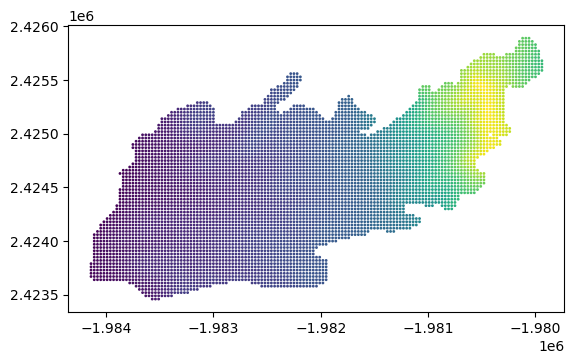

In [58]:
# plot with dem fill value, small points
gdf.plot(column='dem', legend=False, markersize=1, cmap='viridis')

In [19]:
perimdf = open_vectors(PATHS["mtbs_perim"])#.data.to_crs("EPSG:5070")

In [20]:
perimdf.crs

CRS.from_epsg(4269)

In [41]:
# load main dem file as raster and check crs
dem = Raster(PATHS['dem'])
dem.crs

CRS.from_epsg(5070)